## PROBLEMAS COMPARACION PERIODO RETORNO DATOS NEARSHORE

Cuando Ploteo Periodos de Retorno NEARSHORE (hist vs. sim) no sale bien

En este notebook
* Calculo y ploteo periodos de retorno OFFSHORE - DATOS HORARIOS
* Calculo y ploteo periodos de retorno OFFSHORE - DATOS MAXIMOS DE TORMENTAS (PARA HISTORICOS)
* Calculo y ploteo periodos de retorno NEARSHORE - DATOS HORARIOS
* Calculo y ploteo periodos de retorno NEARSHORE - DATOS MAXIMOS DE TORMENTAS (PARA HISTORICOS)

Paso offshore -> nearshore:
* para el historico cargo los datos de oleaje offshore (familias sea, swell1, swell2) 3-horarios del punto offshore input y los paso por RBF_Reconstruction_families()
* para las simulaciones cargo las secuencias de storm generadas con el climate_emulator (familias sea, swell1, swell2) 1-diario y las paso por RBF_Reconstruction_families(), luego utilizo intradaily_hydrographs() para bajar la resolucion temporal a horaria

Comentarios
* llamo "DATOS MAXIMOS DE TORMENTAS" a los que encuentra el emulador climático al ajustarse con los DWTs, buscando el max AWL para cada tormenta.
* aggrego las familias de oleaje y recalculo AWL (por si hubiese algún error previo aquí)
* el aggregar las familias de oleaje se hace cuadrático en todo caso, no parece influir usar el otro metodo (Tp de componente max. energía)
* el horario simulado de OFFSHORE se calcula en notebook 01_Offshore/13_Process_Simulation_Outputs
* el horario simulado de NEARSHORE se calcula en notebook 02_Nearshore/03_SWAN_RBF_Reconstruction

MIS DUDAS
* Cuando uso datos horarios: Si los extremos OFFSHORE salen bien (histórico-simulado), ¿Por qué los extremos NEARSHORE salen mal? Tanto historico como simulado se pasa de OFFSHORE a NEARSHORE usando la misma función...
* Cuando uso únicamente los instantes max_storm del histórico: los extremos NEARSHORE salen mucho mejor. ¿Por qué ocurre ésto?
* ¿Qué le pasa a Hs NEARSHORE? Histórico y Simulado dibujan una "S" en la pendiente de la gráfica, pero no lo hacen en la misma posición... no se interpretar ésto.
* ¿Encontráis alguna razón o motivo para que ocurra ésto? ¿o al verlo suponéis como yo que algo tiene que estar mal?

Le llevo dando vueltas a este asunto mucho, mucho tiempo, no me queda claro qué ocurre y si los resultados NEARSHORE están o no están bien. Necesito consejo para saber por donde seguir porque he probado de todo y aún no entiendo qué ocurre aquí.

A mi parecer (y puedo estar equivocado): si los extremos OFFSHORE horarios hist-sim salen bien, y ambos datos se pasan a NEARSHORE horarios usando el mismo proceso, los extremos NEARSHORE horarios deberían salir bien... pero solo salen "bien" los NEARSHORE - MAX_STORM


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/home/nicolas/Projects/TESLAKIT/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})

## OFFSHORE - DATOS HORARIOS --- SALE BIEN

In [4]:
# --------------------------------------
# Load OFFSHORE hourly waves for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_Complete_hourly()

# Simulation
SIM_C_h = db.Load_SIM_Complete_hourly()


In [5]:
# get max. storms times from offshore hourly file

t_ms = HIST_C_h.where(HIST_C_h.max_storms==True, drop=True).time


In [6]:
# recalculate OFFSHORE AWL

wa = Aggregate_WavesFamilies(HIST_C_h)
for vn in ['Hs', 'Tp', 'Dir']: HIST_C_h[vn] = wa[vn]
HIST_C_h['AWL'] = AWL(HIST_C_h.Hs, HIST_C_h.Tp)

# simulacion agregada con intradaily hydrograph en notebook 01_13
SIM_C_h['AWL'] = AWL(SIM_C_h.Hs, SIM_C_h.Tp) 


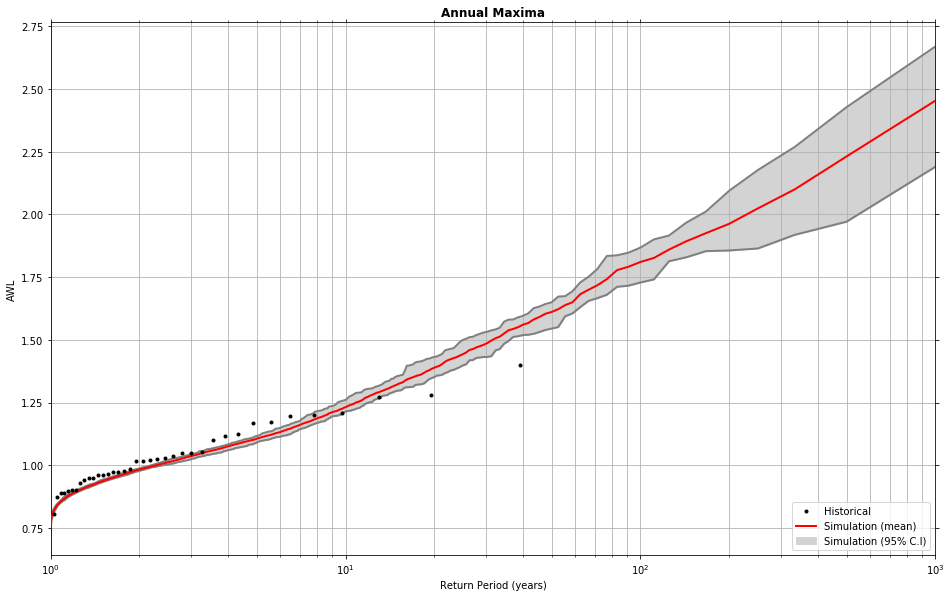

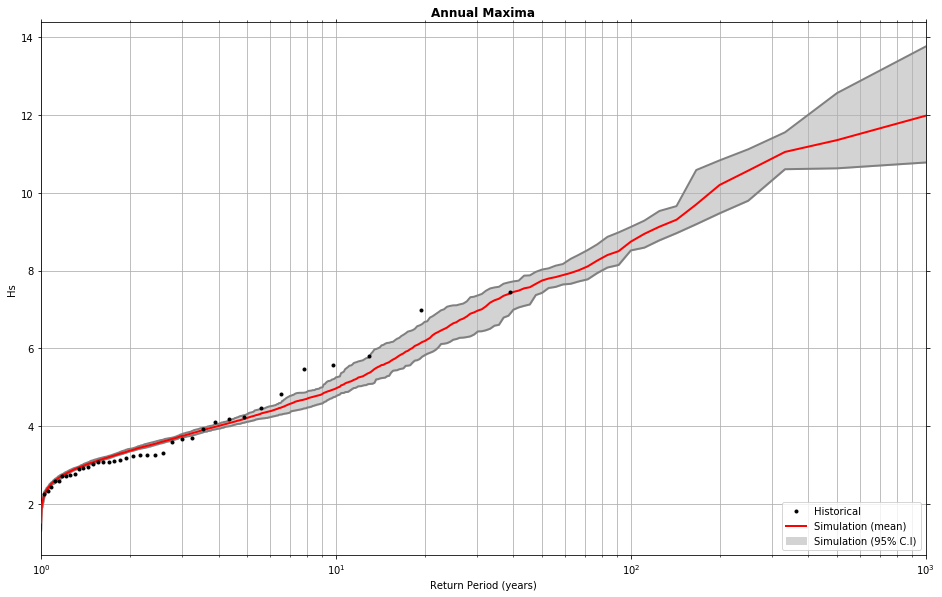

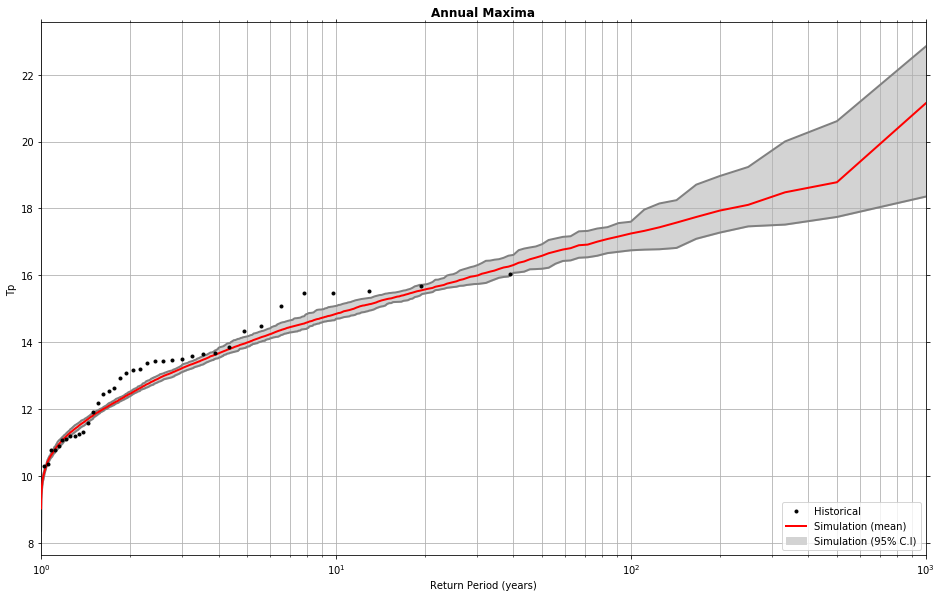

In [7]:
# AWL ANNUAL MAXIMA (AWL, Hs(AWL_annual_max), Tp(AWL_annual_max))

# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Plot return period
Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());


## OFFSHORE - DATOS MAXIMOS DE TORMENTAS (HISTORICOS) --- SALE BIEN

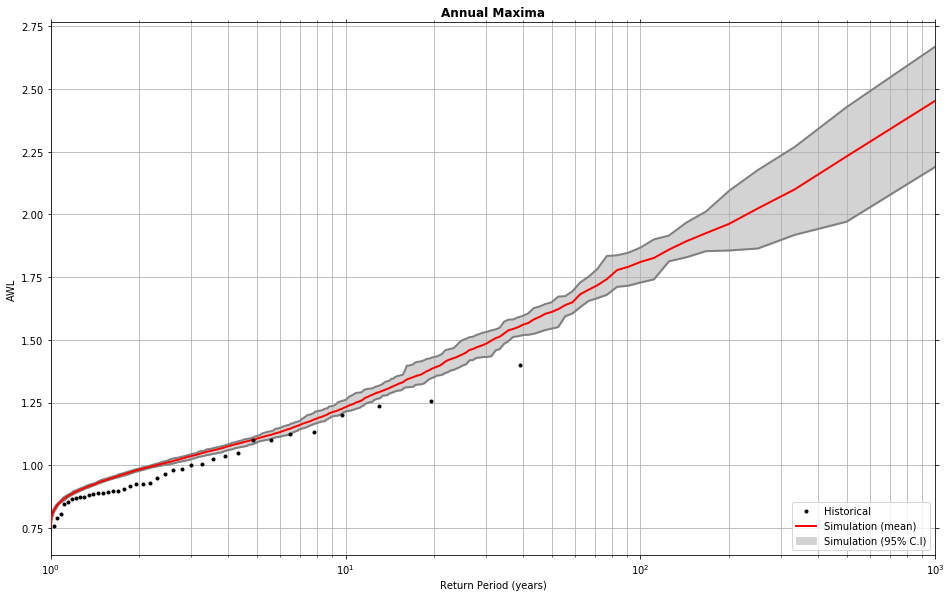

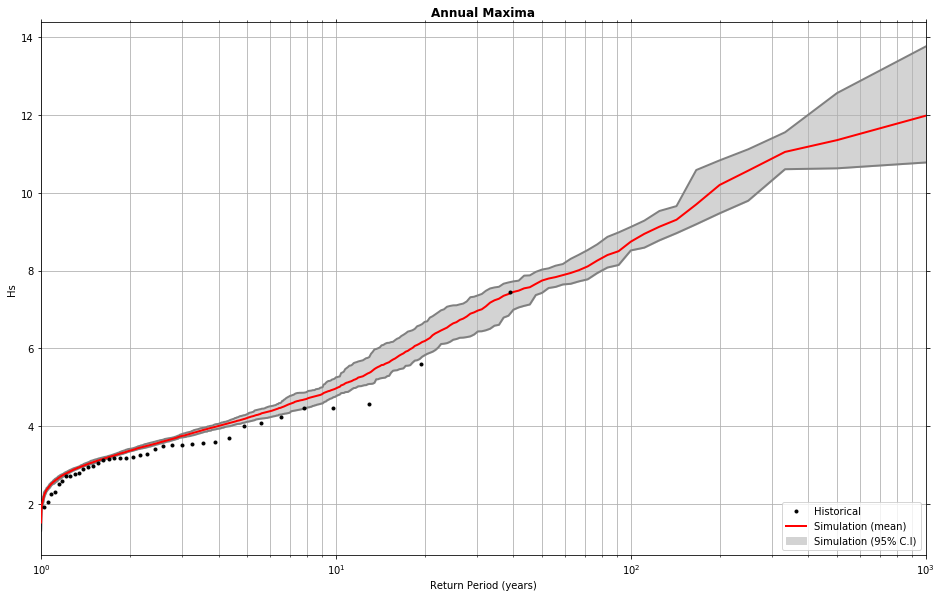

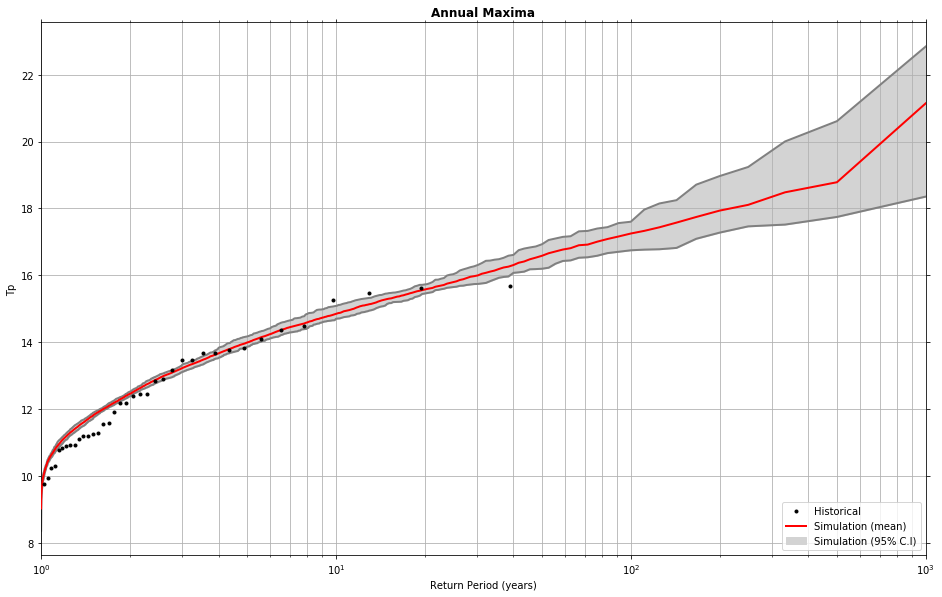

In [8]:

# select max. storms nearshore data for extremes plot
HIST_C_h = HIST_C_h.sel(time = t_ms)

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Plot return period
Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());


## NEARSHORE - DATOS HORARIOS --- SALE MAL

In [9]:
# --------------------------------------
# Load NEARSHORE hourly waves for extremes analysis

# Historical
HIST_N_h = db.Load_NEARSHORE_RECONSTRUCTION_HIST_hourly()

# Simulation
SIM_N_h = db.Load_NEARSHORE_RECONSTRUCTION_SIM_hourly()


In [10]:
# recalculate NEARSHORE AWL

wa = Aggregate_WavesFamilies(HIST_N_h)
for vn in ['Hs', 'Tp', 'Dir']: HIST_N_h[vn] = wa[vn]
HIST_N_h['AWL'] = AWL(HIST_N_h.Hs, HIST_N_h.Tp)


# simulacion reconstruida con intradaily hydrograph en notebook 02_03
SIM_N_h['AWL'] = AWL(SIM_N_h.Hs, SIM_N_h.Tp) 


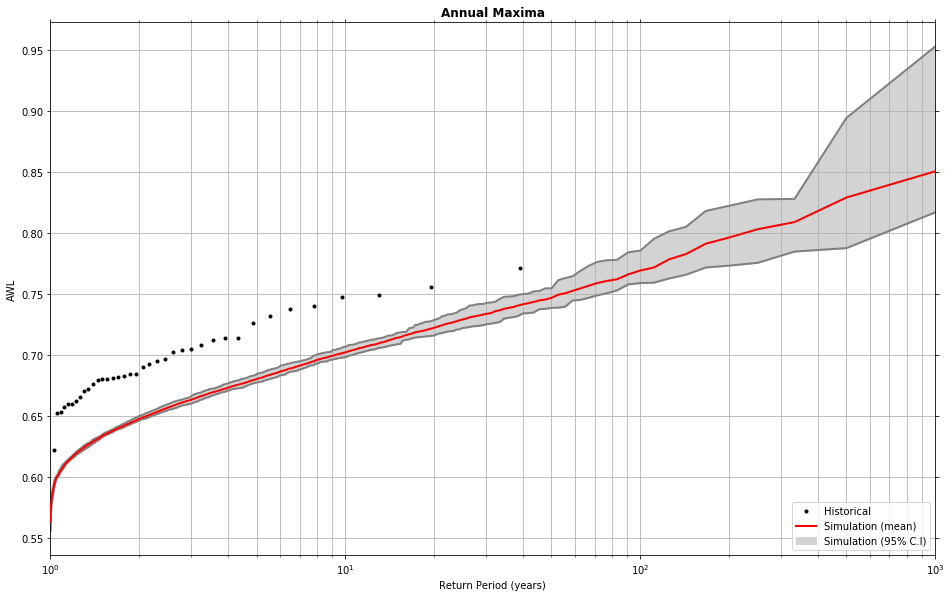

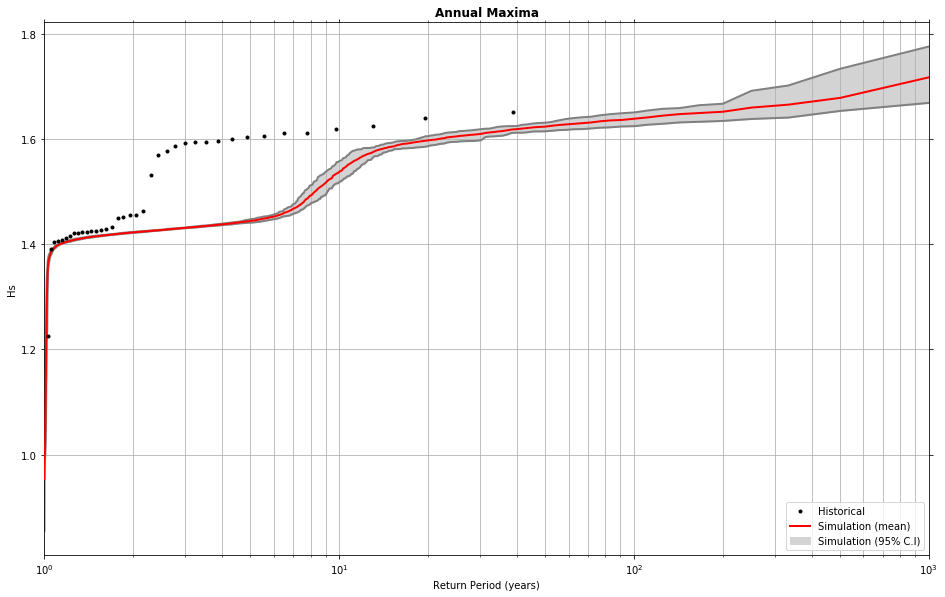

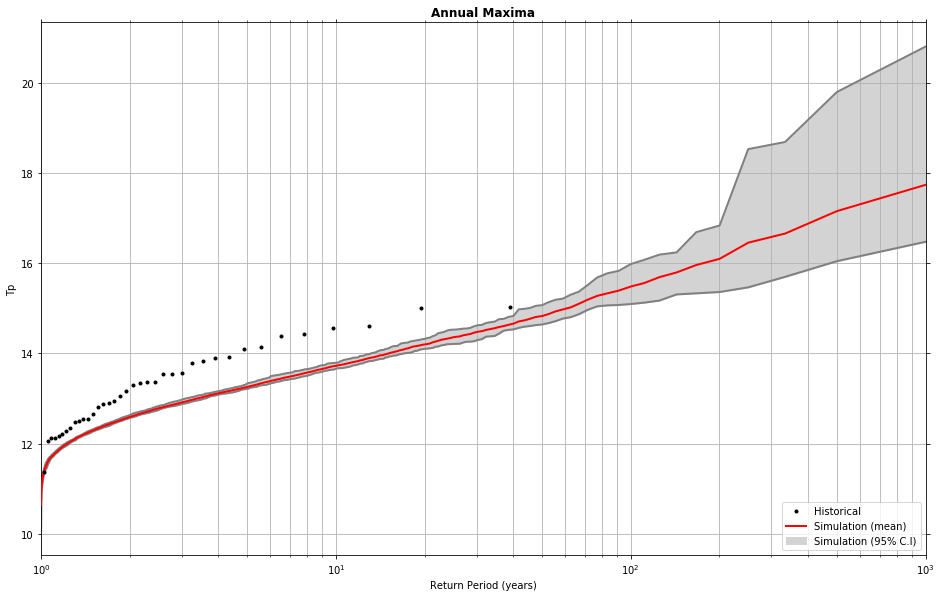

In [11]:
# AWL ANNUAL MAXIMA (AWL, Hs(AWL_annual_max), Tp(AWL_annual_max))


# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_N_h['AWL'].values[:])))
HIST_N_nonan = HIST_N_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_N_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Simulation AWL Annual Maxima

# replace nans by 0
SIM_N_nonan = SIM_N_h.fillna(0)

# calculate AWL annual maxima dataset
sim_AMax = SIM_N_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Plot return period
Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());


## NEARSHORE - DATOS MAXIMOS DE TORMENTAS (HISTORICOS) --- SALE MEJOR

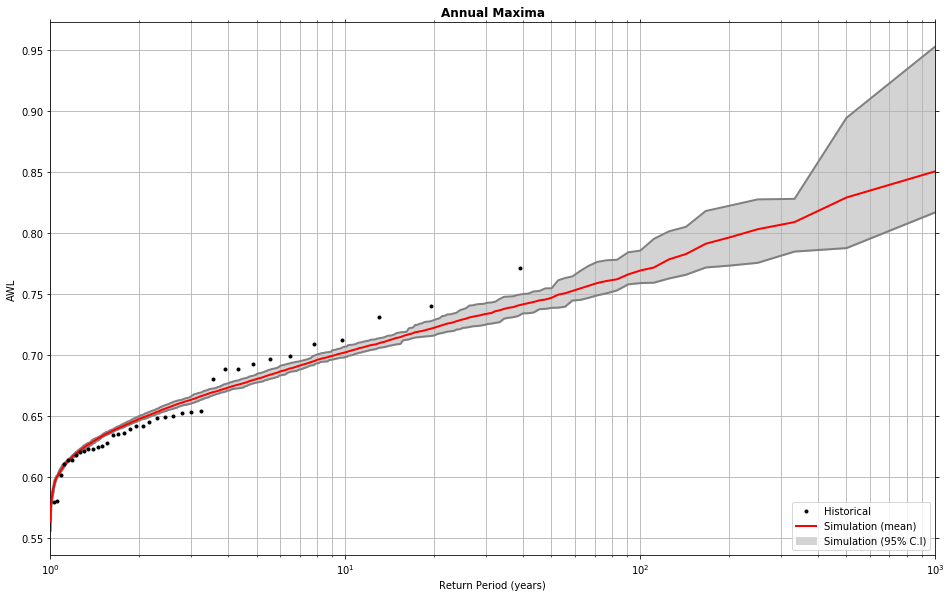

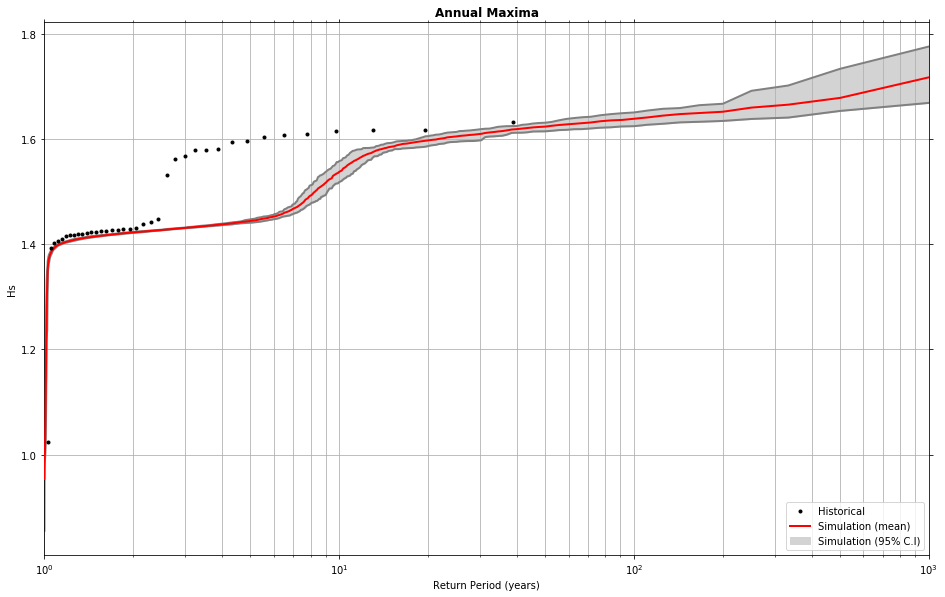

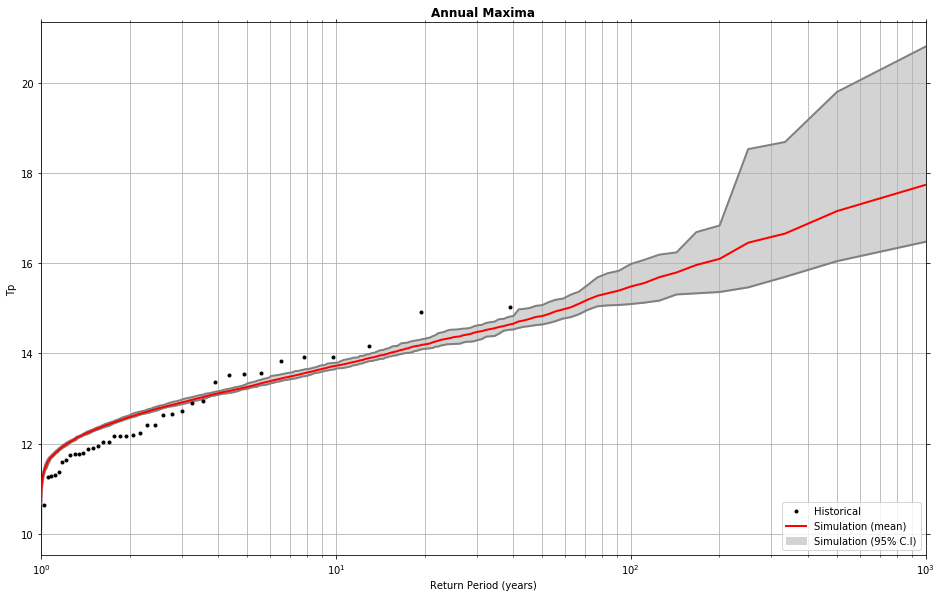

In [12]:

# select max. storms nearshore data for extremes plot
HIST_N_h = HIST_N_h.sel(time = t_ms)

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_N_h['AWL'].values[:])))
HIST_N_nonan = HIST_N_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_N_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


# Plot return period
Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());

